Got graph #0
Generated 5 graphs.


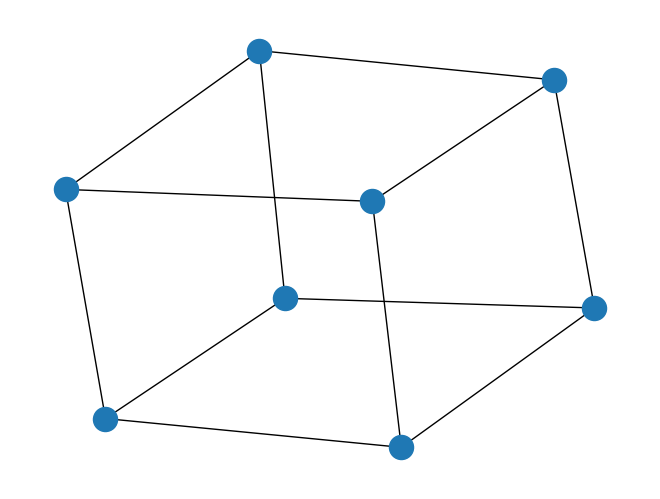

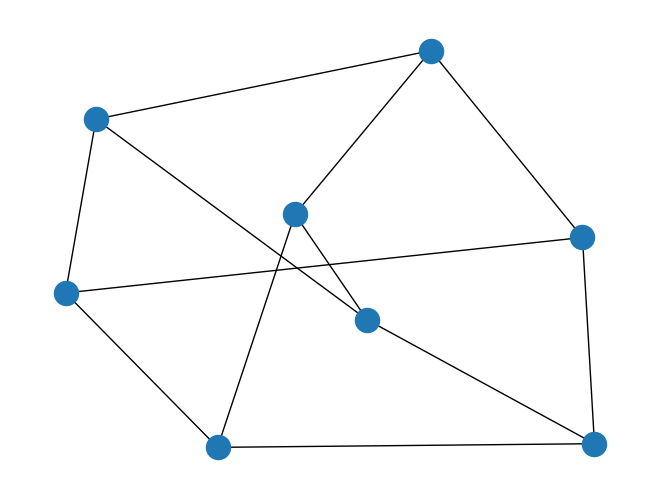

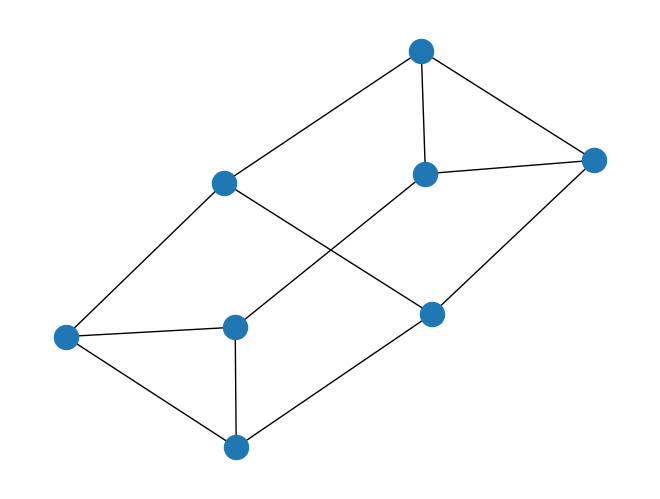

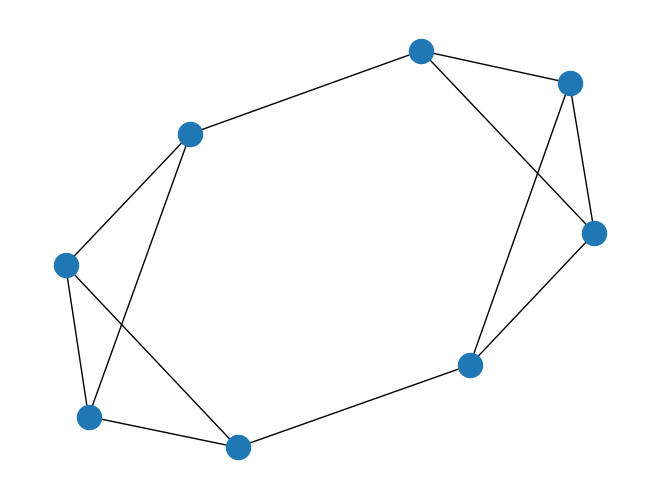

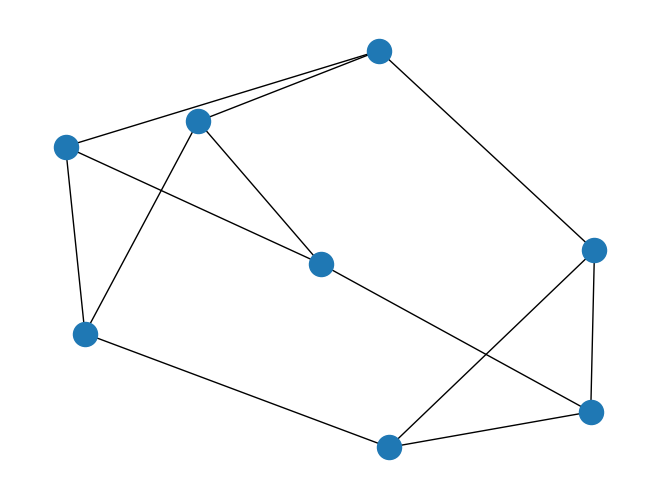

In [18]:
import sys
import networkx as nx
import matplotlib.pyplot as plt
from generate_cubic_graphs import generate_cubic_graphs_with_geng

n = 8
try:
    def simple_progress(g, i):
        if i % 100 == 0:
            print(f"Got graph #{i}")

    graphs = generate_cubic_graphs_with_geng(n, connected=True, per_graph=simple_progress)
    number_of_graphs = len(graphs)
    print(f"Generated {number_of_graphs} graphs.")
    for i, G in enumerate(graphs, 1):
        plt.figure(i)
        nx.draw(G)
except Exception as e:
    print("Error:", e, file=sys.stderr)


Found suitable graph


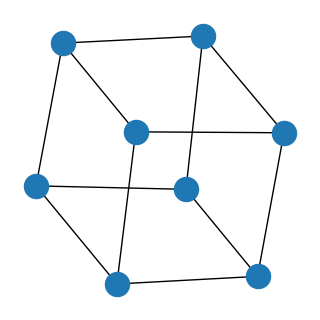

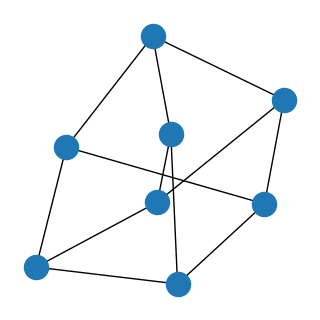

In [23]:
from find_cubic_local_mincut import *
import matplotlib.pyplot as plt

Gs = find_cubic_graph_with_local_cuts(N=8, T=3)
if Gs:
    print("Found suitable graph")
    for i, G in enumerate(Gs, 1):
        plt.figure(i, figsize=(3, 3))
        nx.draw(G)
else:
    print("No graph found")